In [1]:

import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import SAC
from DSAC import DSAC

def evaluate_model(model,env):
    done = False
    rewards = []
    portfolio_worths = []
    obs = env.reset()
    portfolio_worths.append(1.0)
    max_worth = 1.0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done,info = env.step(action)
        current_worth = info[0]['portfolio_worth']
        portfolio_worths.append(current_worth)
        max_worth = max(max_worth,current_worth)
        rewards.append(reward)
    return np.array(rewards),np.array(portfolio_worths)

def calculate_portfolio_metrics(eval_benchmark, portfolio_worths):
    freq = portfolio_worths.shape[0]//15
    
    periodic_portfolio_worths = portfolio_worths[::freq]
    
    periodic_portfolio_returns = np.log(periodic_portfolio_worths[1:]/periodic_portfolio_worths[:-1])
    sharpe_ratio = np.mean(periodic_portfolio_returns)/np.std(periodic_portfolio_returns)
    
    periodic_benchmark_worths = eval_benchmark[::freq]
    periodic_benchmark_returns = np.log(periodic_benchmark_worths[1:]/periodic_benchmark_worths[:-1])
    excess_returns = periodic_portfolio_returns - periodic_benchmark_returns
    information_ratio = np.mean(excess_returns)/np.std(excess_returns)
    
    drawdowns = np.maximum.accumulate(periodic_portfolio_worths) - periodic_portfolio_worths
    max_drawdown = np.max(drawdowns)
    
    print(f'Sharpe Ratio: {sharpe_ratio},  Information Ratio: {information_ratio}, Final Portfolio Worth: {portfolio_worths[-1]}, Max Drawdown: {max_drawdown}')

def evaluate_portfolio(eval_env, eval_benchmark, model):
    rewards,portfolio_worths = evaluate_model(model,eval_env)
    calculate_portfolio_metrics(eval_benchmark, portfolio_worths)
    return portfolio_worths


In [2]:
from std_methods import std_methods

tickers = ['AAPL','JPM','F','PG', 'BA','IBM','XOM']

equal_weights,min_risk,risk_parity = std_methods(tickers,'1992-01-01','2015-18-31','2021-01-01','2024-12-31')

from environments.util import fetch_observations
from environments.benchmark import create_env_benchmark

investment_period = 1 # each 1 investment days 
reward_period = 15 # each 15 investment periods
prices,eval_benchmark,observations,eval_dates = fetch_observations(tickers,investment_period,'2021-01-01','2024-12-31')

eval_env = create_env_benchmark(prices,eval_benchmark,observations,20,0)

print('Equal Weights')
calculate_portfolio_metrics(eval_benchmark, equal_weights)
print('Min Risk')
calculate_portfolio_metrics(eval_benchmark, min_risk)
print('Risk Parity')
calculate_portfolio_metrics(eval_benchmark, risk_parity)



[3.94741434e-01 0.00000000e+00 6.05258566e-01 0.00000000e+00
 0.00000000e+00 3.75157488e-10 0.00000000e+00]
[0.29885389 0.11600899 0.47186395 0.0522108  0.02145406 0.00803142
 0.03157689]
Equal Weights
Sharpe Ratio: 0.3905246772219459,  Information Ratio: 0.2186786589755852, Final Portfolio Worth: 1.658745598828538, Max Drawdown: 0.32420686011359945
Min Risk
Sharpe Ratio: 0.1585066266418099,  Information Ratio: 0.036752190872044004, Final Portfolio Worth: 1.4716057148586068, Max Drawdown: 0.9993610754327897
Risk Parity
Sharpe Ratio: 0.19206859998540196,  Information Ratio: 0.0586637986727892, Final Portfolio Worth: 1.536322644442293, Max Drawdown: 0.8347211321777757


In [3]:
def evaluate_SAC(model_path):
    model = SAC.load(f'./models/{model_path}.zip')
    return evaluate_portfolio(eval_env, eval_benchmark, model)

def evaluate_DSAC(model_path):
    bare_model = DSAC(policy='MlpPolicy', env=eval_env, verbose=1)
    bare_model.set_parameters(f'./models/{model_path}.zip')
    return evaluate_portfolio(eval_env, eval_benchmark, bare_model)

Using cpu device


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.61GB > 1.23GB
  warnings.warn(


Sharpe Ratio: 0.0047506534592211295,  Information Ratio: -0.2302421110165003, Final Portfolio Worth: 1.0406894892234422, Max Drawdown: 0.5157850764163916


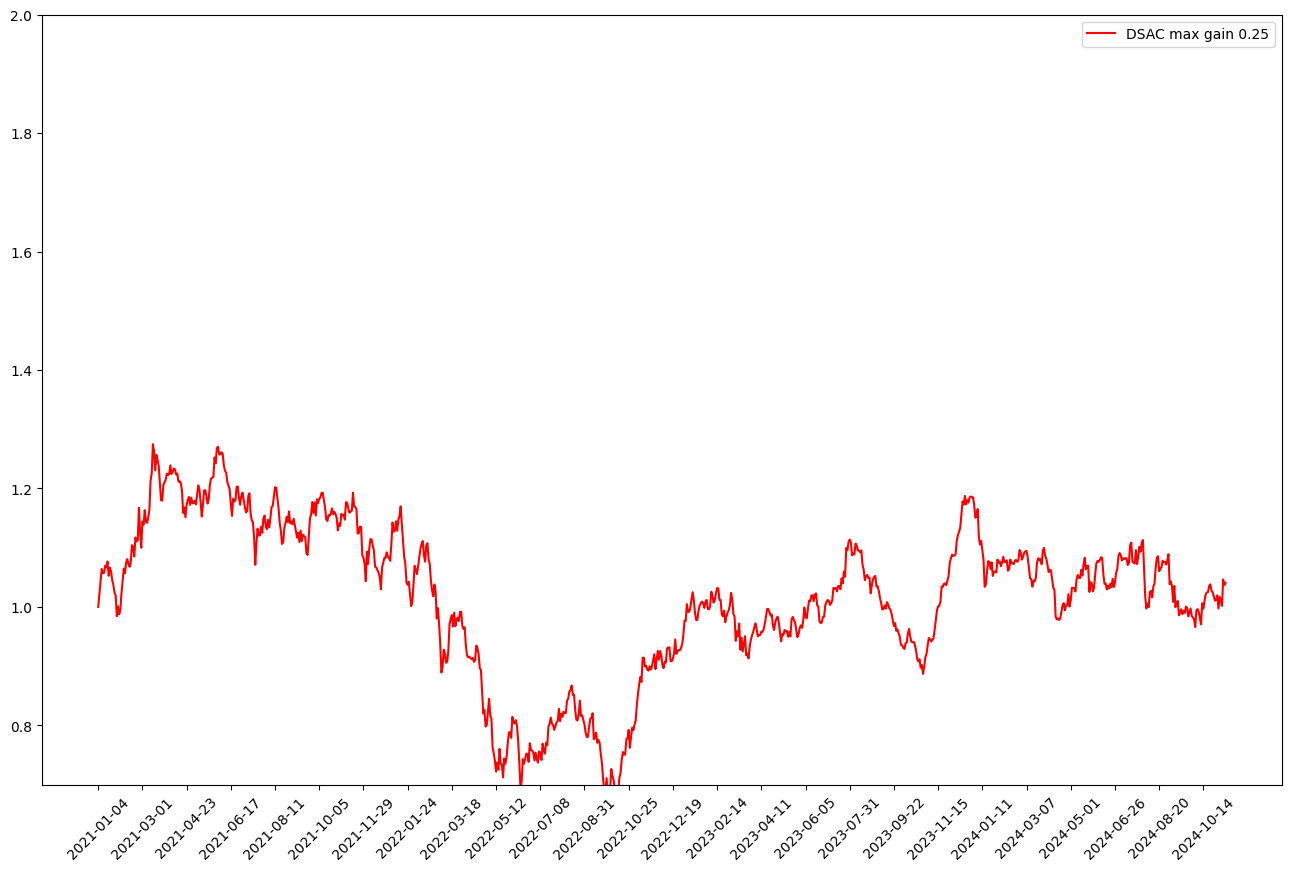

In [4]:
models = {
    'DSAC max gain 0.25':  'DSAC_env_7',
}

plt.figure(figsize=(16,10))
i = 0

colors = ['red','purple','blue','green','orange','pink','gray','brown','yellow','cyan','magenta']

for model_name,model_path in models.items():
    if 'DSAC' in model_path:
        portfolio_worths = evaluate_DSAC(model_path)
    else:
        portfolio_worths = evaluate_SAC(model_path)
    plt.plot(eval_dates,portfolio_worths, linestyle='-',label=f'{model_name}', color = colors[i])
    i += 1
        
eval_benchmark_relative = eval_benchmark/eval_benchmark[0]

plt.xticks(eval_dates[::(len(eval_dates)//25)],rotation=45)
plt.ylim(0.7,2)
plt.legend()